# Batched training

## Overview of batched training process

Batched training is used when the training data is synthetic and so huge, that it cannot fit into memory. Examples are:

* Customer-article fit model. The features of customers and articles can fit into memory, but when we combine them by instances of articles, that were sent to customers, the data explode.
* Natural language processing. When, for instance, processing the sentence of N words, we may wish to construct the training samples so that network predicts $W_i$ word from $(W_1,\ldots,W_{i-1})$ for $i\in[1, N]$. In this case, the data also explode.

Current version of batched training process is *not* dealing with the situation, when the initial data themselves are too big to fit the memory. If this is the case, the current strategy is to get a bigger AWS instance. If it's not feasible, the approach can theoretically be adopted for this case as well.

In batched training, the data are synthesized in _batches_, one after another, and therefore memory is not overused. Consequently, the model must support the iterative training. In our use cases this is always pytorch network, but of course the architecture is not limited to neural networks or some particular implementation of them.

## Data Bundles

As a dataframe is the "all-inclusive" object containing the data for single-frame training, _data bundle_ is such for batched training. The bundle is a set of dataframes, that contains all the data required for batches synthesis, including:
* Index frame. Each row of the index frame describes one instance of data. The row can contain features, labels, or _references_ to other dataframes in bundle
* Data frames. Arbitrary dataframes, normally containing features.

You normally start batched training by creating such bundle, and we will do the same for the Titanic dataset. We will do it in an overcomplicated way, that is totally unnessesary for this particular task, but will allow us to demonstrate available batching techniques. We will separate the available information in Titanic dataset into two parts: information about ticket and information about customer.

In [1]:
import pandas as pd
df = pd.read_csv('titanic.csv')

In rare cases Ticket number does not fully determine the Fare or Embarked column, but we will ignore the exceptions.

In [2]:
tdf = df[['Ticket','Pclass','Fare','Embarked']].drop_duplicates()
bad_tickets = tdf.groupby('Ticket').size()
bad_tickets = bad_tickets.loc[bad_tickets>1]
tdf.loc[tdf.Ticket.isin(bad_tickets.index)].sort_values('Ticket')

,Ticket,Pclass,Fare,Embarked
270,113798,1,31.0000,S
842,113798,1,31.0000,C
138,7534,3,9.2167,S
876,7534,3,9.8458,S
269,PC 17760,1,135.6333,S
325,PC 17760,1,135.6333,C


So the ticket dataframe is:

In [3]:
ticket_df = df[['Ticket','Pclass','Fare','Embarked']].drop_duplicates().drop_duplicates('Ticket').set_index('Ticket')
ticket_df.head()

,Pclass,Fare,Embarked
Ticket,,,
A/5 21171,3,7.2500,S
PC 17599,1,71.2833,C
STON/O2. 3101282,3,7.9250,S
113803,1,53.1000,S
373450,3,8.0500,S


Name is unique across passengers, so we will use it as an index.

In [4]:
df.groupby('Name').size().sort_values(ascending=False).head()

Name
van Melkebeke, Mr. Philemon                1
Goldschmidt, Mr. George B                  1
Graham, Miss. Margaret Edith               1
Goodwin, Mrs. Frederick (Augusta Tyler)    1
Goodwin, Mr. Charles Edward                1
dtype: int64

In [5]:
passenger_df = df[['Name','Sex','Age','SibSp','Parch']].set_index('Name')
passenger_df.head()

,Sex,Age,SibSp,Parch
Name,,,,
"Braund, Mr. Owen Harris",male,22.0,1,0
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0
"Heikkinen, Miss. Laina",female,26.0,0,0
"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0
"Allen, Mr. William Henry",male,35.0,0,0


Now, we will build the index, and then bundle

In [6]:
index_df = df[['PassengerId','Name','Ticket','Cabin','Survived']].set_index('PassengerId')
index_df.Survived = index_df.Survived.astype(float)
index_df.head()

,Name,Ticket,Cabin,Survived
PassengerId,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,0.0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,1.0
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,1.0
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,1.0
5,"Allen, Mr. William Henry",373450,NaN,0.0


In [7]:
from tg.common.ml import batched_training as bt

bundle = bt.DataBundle(
    index_frame = index_df,
    data_frames=dict(
        passengers = passenger_df,
        tickets = ticket_df
    ))

Of course, such complicated structure of this bundle is totally unnesessary in this case, and we could just use the entire original dataframe as an index frame. 

Still, it shows how to bundle data together: we use different data sources (e.g. different table from SQL) without any joining or transformation, and bind them together by index frame.

## Batcher

Batch is a dictionary with several dataframes that is used as a direct argument to the model. They have to be aligned (in our case, the tickets should correspond to the respective passengers), and transformed.

The pipeline to produce batches is:
1. Separate `index_frame` into parts. Each row of `index_frame` defines one individual training sample, so the batch is defined by a set of the rows, so to say the subset of `index_frame`. This part is done by `TrainingStrategy` class. 
2. For each part, we pull the data from `data_frames` of the bundle and apply transformers to them. The resulting dataframes are then returned as a dictionary, which is then fed to the model for training or prediction. This is done by one or many `Extractor`.

The size of the batch is determined by the parameter `batch_size`. The rule of thumb is to select the biggest possible `batch_size` that still does not overfill the memory of the machine.

### Training Strategy

Simple batcher strategy simply separates the frame into subsequent parts of the desired size

In [8]:
strategy = bt.SimpleBatcherStrategy()
test_df = pd.DataFrame(dict(x=list(range(5))))
test_df

,x
0,0
1,1
2,2
3,3
4,4


`SimpleBatchingStrategy` simply separates the dataframe into the consequent subsets of appropriate size

In [9]:
strategy = bt.SimpleBatcherStrategy()
batch_count = strategy.get_batch_count(3,test_df)
print(batch_count)
for i in range(batch_count):
    print(list(strategy.get_batch(3,test_df,i)))

2
[0, 1, 2]
[3, 4]


We also have `PriorityRandomBatcherStrategy`, that randomly samples rows from index frame, paying attention to the indicated weights. That can be used to balance underrepresented samples in the dataset. All of the generated batches will be of the `batch_size`, even if it's greater that dataframe size.

In [10]:
strategy = bt.PriorityRandomBatcherStrategy('x')
batch = strategy.get_batch(10000, test_df, 0)
test_df.loc[batch].groupby('x').size()

x
1     948
2    2096
3    3002
4    3954
dtype: int64

The Titanic dataset's balance is okayish

In [11]:
bundle.index_frame.groupby('Survived').size()

Survived
0.0    549
1.0    342
dtype: int64

But let's use PriorityRandomBatcherStrategy nevertheless. First, we need to compute the priority of each row, which reflects imbalance. Fortunately we have a function to do so:

In [12]:
import copy

fixed_bundle = copy.deepcopy(bundle)
fixed_bundle.index_frame['priority'] = bt.PriorityRandomBatcherStrategy.make_priorities_for_even_representation(
    fixed_bundle.index_frame,
    'Survived'
)
fixed_bundle.index_frame.head()

,Name,Ticket,Cabin,Survived,priority
PassengerId,,,,,
1,"Braund, Mr. Owen Harris",A/5 21171,NaN,0.0,0.001821
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,C85,1.0,0.002924
3,"Heikkinen, Miss. Laina",STON/O2. 3101282,NaN,1.0,0.002924
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,C123,1.0,0.002924
5,"Allen, Mr. William Henry",373450,NaN,0.0,0.001821


We see that survived passengers have slighly greater chances to make it to the batch.

**NOTE**: you probably wouldn't do it like that in the real training. The thing is, you don't want to complicate data bundle creation with a model-specific steps like this one. We only do it to demonstrate, how the final Batcher is going to perform. We will show how to do this step properly a little later


By the way, a good rule of thumb here is: **if you need data bundle when initializing the model, you're doing something wrong!** This is true for Single-Frame training as well, but it is especially true for batcher training, because even in our use cases some datasets are too big to be opened on our laptops, and you can only open them at the remote training instance.

## Extractors

Extractors look at the index, provided by strategy, extract data from bundle and apply transformer. Let's define a small sample to see how the results of the extractors look like:

In [13]:
sample = fixed_bundle.index_frame.iloc[10:13]
sample

,Name,Ticket,Cabin,Survived,priority
PassengerId,,,,,
11,"Sandstrom, Miss. Marguerite Rut",PP 9549,G6,1.0,0.002924
12,"Bonnell, Miss. Elizabeth",113783,C103,1.0,0.002924
13,"Saundercock, Mr. William Henry",A/5. 2151,NaN,0.0,0.001821


The most simple case is when data extracted from index itself, which is the case for the label in our case.

In [14]:
label_extractor = bt.IndexExtractor(name='labels',custom_column_name='Survived')
label_extractor.extract(sample,fixed_bundle).value

,Survived
PassengerId,
11,1.0
12,1.0
13,0.0


Cabin also should be extracted from the index, but this time we will need a transformer. We will just use the transformer factory we already built (it's actually quite generic).

**NOTE**: you don't need to `fit` anything manually! Again, we do it just to demonstrate how the classes work. All the fitting is done internally, you only need to define the instances of the corresponding classes. 


In [15]:
from tg.common.ml import dft
from functools import partial

tfac = (dft.DataFrameTransformerFactory()
 .with_feature_block_list(['Survived','Name','Ticket'])
 .on_continuous(dft.ContinousTransformer)
 .on_categorical(partial(
     dft.CategoricalTransformer, 
     postprocessor=dft.OneHotEncoderForDataframe()))
 .on_rich_category(10, partial(
     dft.CategoricalTransformer, 
     postprocessor=dft.OneHotEncoderForDataframe(), 
     replacement_strategy = dft.TopKPopularStrategy(10,'OTHER')
)))

cabin_extractor = bt.IndexExtractor(name='cabin',transformer=tfac, custom_column_name='Cabin')
cabin_extractor.fit(fixed_bundle)
cabin_extractor.extract(sample,fixed_bundle).value

,Cabin_B5,Cabin_B96 B98,Cabin_C22 C26,Cabin_C23 C25 C27,Cabin_D,Cabin_E101,Cabin_F2,Cabin_F33,Cabin_G6,Cabin_NONE,Cabin_OTHER
PassengerId,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


To extract features from other dataframes, we normally use `DirectExtractor`. If the presence of the features is optional, we use `LeftJoinExtractor`, but this is not the case.

In [16]:
passenger_extractor = bt.DirectExtractor(name='passengers',transformer=tfac,custom_index_column='Name')
passenger_extractor.fit(fixed_bundle)
passenger_extractor.extract(sample,fixed_bundle).value

,Age,Age_missing,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
PassengerId,,,,,,,,,,,,,,,,,,
11,-1.770360,False,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12,1.949591,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13,-0.668153,False,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Notice that the resulting dataframe is indexed the same way the `sample` is.

Let's repeat this for tickets as well

In [17]:
ticket_extractor = bt.DirectExtractor(name='tickets',transformer=tfac,custom_index_column='Ticket')
ticket_extractor.fit(fixed_bundle)
ticket_extractor.extract(sample,fixed_bundle).value

,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
11,-0.178002,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12,0.088698,1.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-0.412210,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Now, we have 4 extractors, but we really do not need so much dataframes in batches. We only need have features and labels. So we will unite the feature extractors into one:

In [18]:
feature_extractor = bt.CombinedExtractor('features',[cabin_extractor, passenger_extractor, ticket_extractor])
feature_extractor.fit(fixed_bundle)
feature_extractor.extract(sample,fixed_bundle).value

,Cabin_B5,Cabin_B96 B98,Cabin_C22 C26,Cabin_C23 C25 C27,Cabin_D,Cabin_E101,Cabin_F2,Cabin_F33,Cabin_G6,Cabin_NONE,...,Parch_5,Parch_6,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_NONE,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,-0.178002,0.0,0.0,1.0,0.0,0.0,0.0,1.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.088698,1.0,0.0,0.0,0.0,0.0,0.0,1.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-0.412210,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Batcher

Now we are ready to define the Batcher:

In [19]:
batcher = bt.Batcher(
    batch_size = 1000,
    extractors = [feature_extractor, label_extractor],
    batching_strategy = bt.PriorityRandomBatcherStrategy('priority')
)

Let's take a look at the batch produced

In [20]:
batcher.fit_extractors(fixed_bundle)
batch = batcher.get_batch(bt.IndexedDataBundle(fixed_bundle, bundle.index_frame.index),0)
list(batch)

['index', 'features', 'labels']

The batch is balanced

In [21]:
batch['labels'].groupby('Survived').size()

Survived
0.0    499
1.0    501
dtype: int64

Obviously, some people are presenting in the batch more than once, because we requested the batch to be bigger than dataset:

In [22]:
batch['index'].groupby('Name').size().mean()

1.6863406408094435

## Model Handler

`ModelHandler` is another important component of the batched training. It handles the model, namely:

* Instantiates the model. For neural network, this step is non-trivial, because we don't really know how much features we have before we fit all the extractors. Thus, we don't really know how much inputs network should have. To instantiate the model, a sample batch is created and passed to the initialization method to address this.
* Implements training on one batch. Again, this is more complicated in case of neural networks than just calling a `fit` method. 
* Implements the prediction. For different tasks, we interpret the network's output differently. In Single Frame Training, we had Evaluation to address this. Still, here the options are more plentiful, so it's moved into `ModelHandler` as well.

For the binary classification, we convinently have all the classes already in place, so we will use them. Check their code to learn how:
* convert dataframes to pytorch tensors
* convert tensors back for prediction
* implement neural network
* train it

In our use cases, we basically were rewriting handlers and networks for each task, and it seems to be a way to do it. We don't really have any special guidelines how to do that, everything is fine as far as the architectural classes are inherited properly.

In [23]:
from tg.common.ml.batched_training import torch as btt
import torch

def initializer(task, batch):
    network = btt.MultiLayerPerceptronWithParsing(
            batch,
            ['features'],
            [10,1])
    return btt.TorchModel(
        network = network,
        optimizer = torch.optim.SGD(network.parameters(), lr=1), #omit for default
        loss = torch.nn.MSELoss() #omit for default
    )
        
    

handler = btt.TorchClassificationModelHandler(
    labels='labels',
    initializer = initializer
)

# Training task

Aside from `ModelHandler` and `Batcher`, `BatcherTrainingTask` is initialized with the classes, already covered in the previous demo: 
* `splitter` to split the index frame to test and train dataset,
  * For batch training, the splitter _must_ return just one split. K-fold is not supported here, because the time of one model training is simply too long.
  * For batch traiing, the train set is not evaluated, because, again, it takes too much time for the big datasets. So what we will do is adding additional `display` subset, which is part of training, but on which the metrics are computed.
* `metrics_pool` to compute metrics
* `artificiers` to inject arbitrary code into training

Also, there is a `settings` object that contains some self-explainatory fields.

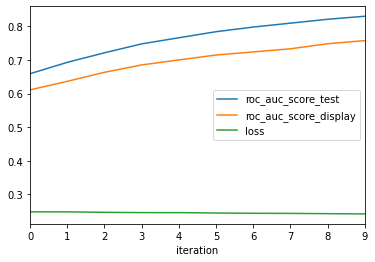

In [24]:
from sklearn.metrics import roc_auc_score

splitter = bt.CompositionSplit(
    bt.FoldSplitter(test_size=0.2),
    bt.FoldSplitter(test_size=0.2, decorate=True, test_name='display')
)

task = bt.BatchedTrainingTask(
    splitter = splitter,
    batcher = batcher,
    model_handler=handler,
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=10)
)

result = task.run(fixed_bundle)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()
pass

Feel free to explore other fields of `result` as well. We hope the name of the fields are quite self-explanatory.

Training can be continued, in this case history persists and the models are not recreated.

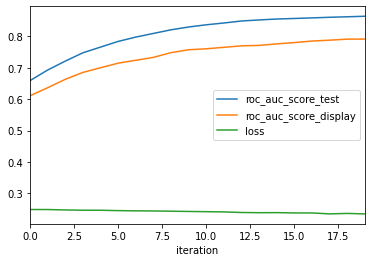

In [25]:
task.settings.continue_training=True
result = task.run(fixed_bundle)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()
pass

You don't have to use the same bundle for continuation. So it's totally feasible to tune our models with newly available data instead of retrain them from scratch every time. 


# Late Initialization

Late initialization allows you to:
* alter data in the bundle when they were loaded
* initialize or modify arbitrary fields of the task, based on loaded data

There are several use cases for that:
* Your model might require some additional data columns, that are simply not in the bundle. In our case, it's a row priority, which we hacked into the bundle while discussing `BatchingStrategy`. The proper way is to compute this field in late initialization.
* Train one model, assemble the second one from the components of the first one, and then train the second one. In this case, some components may need initialization/correction.

For both of these purposes, you can inject an arbitrary method with late initialization. This method accepts task, bundle and environment (for logging purposes), and can modify any of those.

Actually, late initialization is also implemented in single-frame training, but for this one we don't really have the use cases yet.

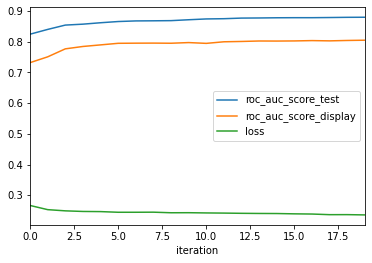

In [26]:
def late_initialization(task, bundle, environment):
    bundle.index_frame['priority'] = bt.PriorityRandomBatcherStrategy.make_priorities_for_even_representation(
        bundle.index_frame,
        'Survived'
    )


task = bt.BatchedTrainingTask(
    splitter = splitter,
    batcher = batcher,
    model_handler=handler,
    metric_pool = bt.MetricPool().add_sklearn(roc_auc_score),
    settings = bt.TrainingSettings(epoch_count=20),
    late_initialization=late_initialization
)

result = task.run(bundle)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()
pass

# Hyperparameter tuning

Implemented exactly the same way as in single-frame training. 